# Data Cleaning & Preparation: Airbnb Listing data for Vienna, Austria
Melina Wettstein <br>
Last Updated: September 7, 2023

<b> Goal: </b> 

To explore Airbnb data from Vienna, Austria and demonstrate cleaning messy data with pandas. The ultimate goal would be to go onto use this data in machine learning algorithms. Note that some of this cleaning is for exploratory and demonstative purposes and should be done more efficiently via Pipelines after splitting the data to avoid issues of data-leakage. 

<b> Main Methods: </b> 
- Duplicate rows were removed, including listings with slight variations but thought to represent the same rental unit. 
- To deal with missing data: 
    - Columns with majority null values were removed
    - Rows with >20 missing values were removed.
    - Categorical columns with missing values had a category added: `unknown`
    - Continuous columns with missing values were dealt with via two different methods:
        - Binning the data into categories including an `unknown` category
        - Filling the unknown values with the median for the column. 
    - Some columns had logical assumptions (i.e. There must be > 1 bed)
    - Boolean columns were changed to 1's and 0's and null values were filled logically (i.e. `host_is_superhost` can be assumed False if not specified as True). 
- The response variable was screened for logical values and removal of outliers. 
- Other columns needed to be changed due to hosts filling them in incorrectly, typos, or two values meaning essentially the same thing but being typed differently (i.e. `2-bath` vs `2-baths`. Examples of cleaning this include: 
    - Functions to clean strings into floats, for example the number of baths a unit has. 
    - Removing typo's in neighborhood names. 
    - Classifying property type into 5 recognizable types rather than host specified. 
    - Taking list of amenities from `amenities` column and turning each important amenity into its own boolean column with 1 if present and 0 else. 
- Finally, categorical variables were one-hot encoded and the data was split (Note again, this would have taken place at a different location in a real machine learning implementation). 

### About the data

This dataset is a collection of listings from Airbnb in Vienna, Austria. The data is collected from Inside Airbnb, which was last updated on June 23, 2023. The data is messy, given all the long text fields, large amounts of missing data, and a lot of features that are not helpful in predicting prices. 

This notebook shows the full data cleaning process, including the data exploration process. While in a real situation, this would not be included in the final document, data exploration is an important part of the process.

Additionally, all data cleaning and preparation occurred prior to splitting into training and testing sets. Since the goal of this document is showcasing the thought process behind data cleaning rather than accurate models, we did this manually and without concern for data-leakage. In a real implementation for training, some of this would be taken care of with pipelines after splitting the data instead. Specifically this is the case for the review columns, which are filled with median values. Similarly, in an implementation I would probably leave the host reponse rates as continuous values as well, for simplicity in pipelining our data. 


## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# set display columns to max so that we can view all columns
pd.set_option('display.max_columns', None)

In [2]:
# import the Vienna dataset
vienna_raw = pd.read_csv('listings.csv', index_col='id')

# saving raw data as new dataframe for exploration
vienna = vienna_raw.copy()

## Initial Data Exploration

In [3]:
# view number of rows/columns
vienna.shape

(13296, 74)

In [4]:
vienna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13296 entries, 38768 to 909966393679149837
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   13296 non-null  object 
 1   scrape_id                                     13296 non-null  int64  
 2   last_scraped                                  13296 non-null  object 
 3   source                                        13296 non-null  object 
 4   name                                          13296 non-null  object 
 5   description                                   13053 non-null  object 
 6   neighborhood_overview                         7008 non-null   object 
 7   picture_url                                   13296 non-null  object 
 8   host_id                                       13296 non-null  int64  
 9   host_url                                    

In [5]:
vienna.head(3)

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38768,https://www.airbnb.com/rooms/38768,20230610002046,2023-06-10,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Vienna, Austria",I am open minded and like travelling myself. I...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstadt,3.0,3.0,"['email', 'phone']",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21924,16.37831,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Room-darkening shades"", ""Wifi"", ""Kitchen"", ""...",$79.00,7,75,3,14,1125,1125,7.7,1125.0,NaN,t,5,24,54,64,2023-06-10,365,18,2,2011-03-23,2023-05-29,4.75,4.81,4.66,4.91,4.93,4.76,4.70,NaN,t,3,3,0,0,2.45
40625,https://www.airbnb.com/rooms/40625,20230610002046,2023-06-10,city scrape,Rental unit in Vienna · ★4.84 · 2 bedrooms · 4...,Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,https://www.airbnb.com/users/show/175131,Ingela,2010-07-20,"Vienna, Austria",I´m originally from Sweden but have been livin...,within an hour,97%,83%,t,https://a0.muscache.com/im/users/175131/profil...,https://a0.muscache.com/im/users/175131/profil...,Rudolfsheim-Fünfhaus,17.0,19.0,"['email', 'phone']",t,t,"Vienna, Austria",Rudolfsheim-Fnfhaus,NaN,48.18434,16.32701,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",$186.00,1,180,1,3,180,180,1.0,180.0,NaN,t,10,21,51,326,2023-06-10,193,20,2,2010-08-04,2023-05-28,4.84,4.90,4.88,4.89,4.94,4.59,4.71,NaN,t,15,14,1,0,1.23
51287,https://www.airbnb.com/rooms/51287,20230610002046,2023-06-10,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,https://www.airbnb.com/users/show/166283,Hannes,2010-07-14,"Vienna, Austria",I am open minded and like travelling myself. I...,within an hour,100%,100%,t,https://a0.muscache.com/im/users/166283/profil...,https://a0.muscache.com/im/users/166283/profil...,Leopoldstadt,3.0,3.0,"['email', 'phone']",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21778,16.37847,Entire rental unit,Entire home/apt,3,NaN,1 bath,NaN,2.0,"[""Refrigerator"", ""Wifi"", ""Kitchen"", ""Essential...",$71.00,5,60,3,14,11

Notice that there are a lot of features we know immediately will not help us predict price. This includes columns like URLs and information related to the data scraping. We will also delete things like host information. We will keep things that say how many listings a host has and for how long they have been a host because those may be indicators of price. We are not doing analysis on the text in descriptions or names, so we will remove these as well. There are also several values related to maximum and minimum nights possible to book. We will remove all these extra columns except the base values: `minimum_nights` and `maximum_nights`. Finally, there are columns that give repeat information, and we will delete those as well. 

In [6]:
drop_features = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', 
                 'host_thumbnail_url', 'host_picture_url', 'calendar_updated', 'calendar_last_scraped', 
                 'neighborhood_overview', 'host_name', 'host_location', 'host_about', 
                 'host_neighbourhood', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                 'last_review', 'license', 'calculated_host_listings_count_entire_homes', 
                 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
                 'host_listings_count', 'first_review', 'host_since', 'availability_30', 'availability_60', 'availability_90']
vienna = vienna.drop(drop_features, axis=1)
print("New Size of dataset:", vienna.shape)
vienna.head(3)
## NOTE kept  'name', 'description' even though not importatn for analysis

New Size of dataset: (13296, 42)


,name,description,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38768,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,39m² apartment with beautiful courtyard of the...,166283,within an hour,100%,100%,t,3.0,"['email', 'phone']",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21924,16.37831,Entire rental unit,Entire home/apt,5,NaN,1 bath,1.0,3.0,"[""Room-darkening shades"", ""Wifi"", ""Kitchen"", ""...",$79.00,7,75,t,64,365,18,2,4.75,4.81,4.66,4.91,4.93,4.76,4.70,t,3,2.45
40625,Rental unit in Vienna · ★4.84 · 2 bedrooms · 4...,Welcome to my Apt. 1!<br /><br />This is a 2be...,175131,within an hour,97%,83%,t,19.0,"['email', 'phone']",t,t,"Vienna, Austria",Rudolfsheim-Fnfhaus,NaN,48.18434,16.32701,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""First aid kit"", ""Wifi"", ""Kitchen"", ""Essentia...",$186.00,1,180,t,326,193,20,2,4.84,4.90,4.88,4.89,4.94,4.59,4.71,t,15,1.23
51287,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,small studio in new renovated old house and ve...,166283,within an hour,100%,100%,t,3.0,"['email', 'phone']",t,t,"Vienna, Austria",Leopoldstadt,NaN,48.21778,16.37847,Entire rental unit,Entire home/apt,3,NaN,1 bath,NaN,2.0,"[""Refrigerator"", ""Wifi"", ""Kitchen"", ""Essential...",$71.00,5,60,t,122,364,27,2,4.66,4.78,4.52,4.93,4.95,4.86,4.58,f,3,2.42


## Duplicate rows
First, note that there are only 2 rows that are completely duplicated values. And we obviously want to drop these rows. 

In [7]:
print('Number of duplicate rows before: ', vienna.duplicated().sum())
vienna = vienna.drop_duplicates()
print('Number of duplicate rows after: ', vienna.duplicated().sum())

Number of duplicate rows before:  4
Number of duplicate rows after:  0


However, that does not mean that there are not duplicate listings. Airbnb hosts may list the same place several times to optimize bookings for example. We will check this using the `host_id`, `name`, `description`, and `neighbourhood`. Now this cannot always be assumed to be duplicates, however for the case of this analysis, we will assume that they are and remove them. 

In [8]:
print('Number of duplicate listings based on these columns before: ', vienna.duplicated(['host_id', 'name', 'description', 'neighbourhood_cleansed']).sum())
vienna = vienna.drop_duplicates(['host_id', 'name', 'description', 'neighbourhood_cleansed'])
print('Number of duplicate listings based on these columns after: ', vienna.duplicated(['host_id', 'name', 'description', 'neighbourhood_cleansed']).sum())

Number of duplicate listings based on these columns before:  350
Number of duplicate listings based on these columns after:  0


In [9]:
# Now that we identified homes listed several times, we drop un-important info about name/description
vienna = vienna.drop(['name', 'description', 'host_id'], axis = 1)

## Columns with Missing Values

There are several columns not already removed that are mostly or entirely made up of missing values. Below, we see the null counts for all columns where there are null values. We see that 2 columns are entirely null values. These will obviously be dropped. For the columsn with some null values, we can fill these with logical data. Others we will drop. This will be handled on a more individual basis. Finally, some of these columns have data that we need to change the data-type for or reclassify the data. Thus, we will also do this now. 

In [10]:
# initial data shape
vienna.shape

(12942, 39)

In [11]:
null_val = vienna.isnull().sum().sort_values(ascending = False)
null_val[null_val > 0]

bathrooms                       12942
neighbourhood_group_cleansed    12942
neighbourhood                    6059
host_response_time               3751
host_response_rate               3751
bedrooms                         3450
host_acceptance_rate             3174
host_is_superhost                2538
review_scores_value              2095
review_scores_checkin            2095
review_scores_location           2094
review_scores_cleanliness        2094
review_scores_accuracy           2094
review_scores_communication      2093
review_scores_rating             2015
reviews_per_month                2015
beds                              146
bathrooms_text                      3
host_total_listings_count           1
host_has_profile_pic                1
host_identity_verified              1
dtype: int64

In [12]:
# using drop_na to drop columns that have all missing values
vienna = vienna.dropna(axis = 1, how='all')

The above code takes care of the columns with completely missing values. 

Now, let's consider the `neighbourhood` column. For this, about half the values are missing. However, we also have the `neighbourhood_cleansed` column, which includes neighborhood information calculated using latitude and longitude from the listing. This column has no missing values. Thus, we can drop `neighbourhood` without losing any information other than the self-identified neighborhood by the host. 

In [13]:
vienna['neighbourhood_cleansed'].isnull().sum()

0

In [14]:
vienna = vienna.drop(['neighbourhood'], axis = 1)
vienna.shape

(12942, 36)

Quickly, we also want to take care of rows with too many missing values. We have assumptions to fill certain columns, but we want to make sure that columns don't have too much missing data. 

In [15]:
vienna = vienna.dropna(thresh = 20)
vienna.shape

(12942, 36)

Since `host_response_time` is already a categorical variable, we will fill the null values with a string. The assumption here is that hosts with a Null value in this column have never had messages to respond to. we will just fill the null values with a value 'unknown' to indicate the host never had a response and/or that that time is unknown. This is kept as its own category because this may be a predictor. 

In [16]:
vienna['host_response_time'].value_counts() #fill with "unknown"

within an hour        7148
within a few hours    1087
within a day           732
a few days or more     224
Name: host_response_time, dtype: int64

In [17]:
vienna['host_response_time'] = vienna['host_response_time'].fillna('unknown')

For rates in relation to the host, `host_response_rate` and `host_acceptance_rate` we will turn these into categorical bins, with Null values being a category in these bins called 'unknown'. These could be kept as continuous values and filled with median values instead. For exploration purposes, the categorical method is shown here, and filling with median values is shown below, for the reviews columns. 

In [18]:
vienna['host_acceptance_rate']

id
38768                 100%
40625                  83%
51287                 100%
70637                  87%
75500                  25%
                      ... 
909396115406439281    100%
909443120550011473     NaN
909516740781088182    100%
909530842310963309    100%
909966393679149837     NaN
Name: host_acceptance_rate, Length: 12942, dtype: object

In [19]:
# Turn from string to float
vienna.loc[:,'host_acceptance_rate'] = vienna.loc[:,'host_acceptance_rate'].str.replace('\%', '', regex=True).astype(float)
vienna.loc[:,'host_response_rate'] = vienna.loc[:,'host_response_rate'].str.replace('\%', '', regex=True).astype(float)

#Create Bins
bins = [0,49, 79, 89, 99, 100]
vienna['host_acceptance_rate'] = pd.cut(vienna['host_acceptance_rate'], bins, 
                                       labels=['0-49', '50-79', '80-89', '90-99', '100'])
vienna['host_response_rate'] = pd.cut(vienna['host_response_rate'], bins, 
                                       labels=['0-49', '50-79', '80-89', '90-99', '100'])

# Add 'unknown' bin and fill the NA values
vienna['host_acceptance_rate'] = vienna['host_acceptance_rate'].cat.add_categories('unknown')
vienna['host_acceptance_rate'] = vienna['host_acceptance_rate'].cat.reorder_categories(['unknown', '0-49', '50-79', '80-89', '90-99', '100'])
vienna['host_acceptance_rate'].fillna('unknown', inplace = True)

vienna['host_response_rate'] = vienna['host_response_rate'].cat.add_categories('unknown')
vienna['host_response_rate'] = vienna['host_response_rate'].cat.reorder_categories(['unknown', '0-49', '50-79', '80-89', '90-99', '100'])
vienna['host_response_rate'].fillna('unknown', inplace = True)

vienna[['host_acceptance_rate','host_response_rate']].head(3)


,host_acceptance_rate,host_response_rate
id,,
38768,100,100
40625,80-89,90-99
51287,100,100


For `bedrooms`, we know that it is not logical to have no bedrooms in the context of AirBNB, which is a service dedicated to rent out places to stay. Thus, we will fill the missing bedroom values with 1. 

After filling this, we will consider the `beds` columns. First, we can assume that there is, at a minimum, 1 bed per listing. However, there are cases where the beds are Null, but there are more than 1 bedroom. In these cases, we assume there is a bed per bedroom. Since we already filled the Null values for the `bedrooms` column, we can simply use this column to fill the null values for `beds`. 

Note that these features may be correlated, so we will deal with this later.

In [20]:
vienna['bedrooms'] = vienna['bedrooms'].fillna(1)

In [21]:
# Numbers of bedrooms for the Null values in beds
vienna[['bedrooms']][vienna['beds'].isnull()].value_counts()

bedrooms
1.0         132
2.0          11
3.0           2
4.0           1
dtype: int64

In [22]:
vienna['beds'] = vienna['beds'].fillna(vienna['bedrooms'])

We will handle the `host_is_superhost`, `host_has_profile_pic`, and `host_identity_verified` columns similarly, as they are all supposed to be boolean values, and all can operate under the assumption that if they are not true, then they are false. For example, if a host's superhost status is null, we can assume they are not a superhost. Also, these are all strings of `t` and `f` that should represent boolean values, so we will change these to 0's and 1's. 

In [23]:
vienna['host_is_superhost'] = vienna['host_is_superhost'].fillna(0)
vienna['host_has_profile_pic'] = vienna['host_has_profile_pic'].fillna(0)
vienna['host_identity_verified'] = vienna['host_identity_verified'].fillna(0)

In [24]:
# transform t/f values to 1 and 0 
vienna.loc[vienna['host_is_superhost'] == 't', 'host_is_superhost'] = 1
vienna.loc[vienna['host_is_superhost'] == 'f', 'host_is_superhost'] = 0

vienna.loc[vienna['host_has_profile_pic'] == 't', 'host_has_profile_pic'] = 1
vienna.loc[vienna['host_has_profile_pic'] == 'f', 'host_has_profile_pic'] = 0

vienna.loc[vienna['host_identity_verified'] == 't', 'host_identity_verified'] = 1
vienna.loc[vienna['host_identity_verified'] == 'f', 'host_identity_verified'] = 0

#others
vienna.loc[vienna['has_availability'] == 't', 'has_availability'] = 1
vienna.loc[vienna['has_availability'] == 'f', 'has_availability'] = 0

vienna.loc[vienna['instant_bookable'] == 't', 'instant_bookable'] = 1
vienna.loc[vienna['instant_bookable'] == 'f', 'instant_bookable'] = 0


Dealing with the reviews is more difficult. 

First, we assume that if there are an unknown number of reviews per month, that there are either no reviews, or similar. Thus, we will fill this column with 0. 


In [25]:
vienna['reviews_per_month'] = vienna['reviews_per_month'].fillna(0)

Next, we will look at the values of reviews themselves. One option is to consider these as bins as above. Another is to simply fill the null values with the median review value. This allows us to use these as continuous rather than categorical data, which may help with predictions depending on the algorithm applied. Note that because we are filling null values with a median prior to splitting the data, this is for demonstration purposes only. In a real implementation, this should occur in a pipeline after the data has been split. 

In [26]:
from sklearn.impute import SimpleImputer

review_col = ['review_scores_rating', 'review_scores_checkin', 'review_scores_value', 'review_scores_location', 
              'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication' ]

impute = SimpleImputer(strategy='median')
vienna[review_col] = impute.fit_transform(vienna[review_col])

vienna[review_col].isna().sum()


review_scores_rating           0
review_scores_checkin          0
review_scores_value            0
review_scores_location         0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_communication    0
dtype: int64

Next, we will deal with the `bathrooms_text` column. Again, this is a case where it is not logical to not have a bathroom. Thus, we will fill this with 1. We will also change the rest of these strings to floats. We need to strip off the extra text, then we use a function to change values containing 'half' to 0.5.

In [27]:
def half_to_num(text):
    #print(text)
    text = text.strip(' shared baths').strip(' priv')
    if 'half' in str(text).lower():
        return '0.5'
    else:
        return text
    
vienna['bathrooms_text'] = vienna['bathrooms_text'].fillna('1.0').apply(lambda row: half_to_num(row)).astype('float64')

Finally, the host_total_listings_count only has one missing value. We will simply assume that this listing is the host's only listing and fill the null value with 1. (This was confirmed by using the original data before additional columns were removed). 

In [28]:
vienna['host_total_listings_count'] = vienna['host_total_listings_count'].fillna(1)

In [29]:
null_val = vienna.isnull().sum().sort_values(ascending = False)
null_val[null_val > 0]
# This being empty shows there are no more null values!!

Series([], dtype: int64)

## Our Response Variable: Price
First, note that price, which is the value we want to predict, is a string. We instead want this to be a float. Thus, the following code removes the dollar signs and commas, and changes the type to a float. Since this is our response variable, we also want to ensure that outliers and illogical values do not mess up the data. 

In [30]:
vienna['price'] = vienna['price'].str.replace('\$', '', regex=True).str.replace(',','').astype(float)

When we look at the histogram of price, we see that there are some clear outliers, causing our distribution to be very right skewed. We will remove the top 1%, assuming they are outliers. When we search for the minimum price, we see that there are listings where a price is listed at `$0`. However, this does not seem realistic so we will drop it. There are still very low values, but may be reasonable for shared rooms in less desirable areas, so we will not immediately drop these to an arbitrary cut off. On the maximum end, we will use the 99th quantile to remove outliers. This drops the max price from almost `$10,000` to only `$585`. Note that the data is still right skewed but we can at least observe the distribution now. 

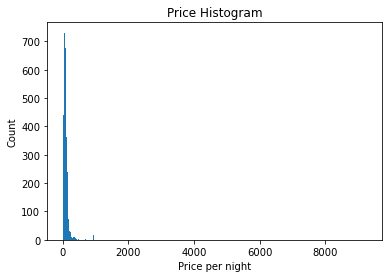

In [31]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.hist(vienna['price'], bins = 'auto')
ax.set_title('Price Histogram')
ax.set_xlabel('Price per night')
ax.set_ylabel('Count')
plt.show()

In [32]:
print('Min price:', vienna['price'].min()) #Obviously not logical so let's remove when the price is $0
vienna = vienna.drop(vienna[vienna['price'] == 0].index)
print('Min price after:', vienna['price'].min()) # Still maybe an error, but may be reasonable for a small shared room, we will leave


Min price: 0.0
Min price after: 8.0


In [33]:
print('Max price:', vienna['price'].max())
print('99th percentile:', vienna['price'].quantile(.99))
# 99th percentile is way less than the max, so we will remove the outliers. 
vienna = vienna.drop(vienna[vienna['price'] > vienna['price'].quantile(.99)].index)
print('Max price after:', vienna['price'].max())

Max price: 9270.0
99th percentile: 588.0000000000018
Max price after: 585.0


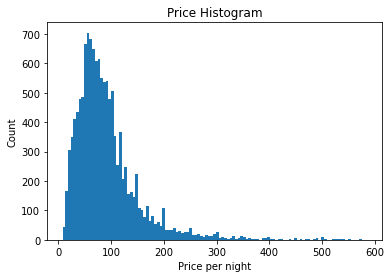

In [34]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,1)
ax.hist(vienna['price'], bins = 'auto')
ax.set_title('Price Histogram')
ax.set_xlabel('Price per night')
ax.set_ylabel('Count')
plt.show()

## Dealing with Columns with Non-Null values
Above, we dealth with columns that had null values. The columns without null values still need to be updated though. For example, there are issues with data types and typos in columns. There are also columns that have lists of information, and we want to separate these into their own columns. 

First, there are issues with neighbourhood_cleansed. There are names with foreign characters which did not translate the dataset. Thus, the following code fixes these typos. 

In [35]:
neighborhood_names_new = {'Landstra§e':'Landstrasse', 
                         'Rudolfsheim-Fnfhaus':'Rudolfsheim-Funfhaus',
                         'Whring':'Wahring',
                         'Dbling':'Dobling'}
vienna['neighbourhood_cleansed'] = vienna['neighbourhood_cleansed'].map(neighborhood_names_new).fillna(vienna['neighbourhood_cleansed'])

For the `host_verifications` column, the column is a string that has different ways the host is verified. The following code takes the strings from this column and marks them as true or false in the new columns: `host_email` if they are verified by email, `host_work_email` if their work email is verified, and `host_phone` if their phone is verified. Finally, we drop the `host_verifications` columns since it no longer has information we need. 

In [36]:
vienna['host_verifications'].value_counts()

['email', 'phone']                  9982
['email', 'phone', 'work_email']    1783
['phone']                            968
['phone', 'work_email']               57
['email']                             15
[]                                     4
None                                   1
['email', 'work_email']                1
Name: host_verifications, dtype: int64

In [37]:
vienna.loc[vienna['host_verifications'].str.contains("'email'", case=False), 'host_email'] = 1
vienna.loc[vienna['host_verifications'].str.contains("'work_email'", case=False), 'host_work_email'] = 1
vienna.loc[vienna['host_verifications'].str.contains("'phone'", case=False), 'host_phone'] = 1
vienna[['host_email', 'host_work_email', 'host_phone']] = vienna[['host_email', 'host_work_email', 'host_phone']].fillna(0)
vienna[['host_verifications','host_email', 'host_work_email', 'host_phone']]
vienna = vienna.drop(['host_verifications'], axis = 1)

Next, we will look at `property_type`. There are is a lot of variety in the type of property, but some of these are virtually the same, and should not be considered a separate type. Thus, we will replace these and simplify this column significantly. The one big issue is the `Entire rental unit` category. This does not clarify the property type, and we cannot assume the type beyond this, especially since it is such a large group. Thus, we will leave this alone. 

In [38]:
vienna.replace(['Entire apartment', 'Entire serviced apartment', 'Entire condo','Entire condominium', 'Entire loft', 
                'Entire guest suite'], 
               'Apartment', inplace = True)
vienna.replace(['Entire house', 'Entire home', 'Entire vacation home', 'Entire townhouse', 'Entire villa', 
                'Entire bungalow', 'Entire guesthouse', 'Entire cottage', 'Entire chalet', 'Entire cabin', 'Entire place'], 
               'House', inplace = True)
vienna.loc[vienna['property_type'].str.contains('room', case = False), 'property_type'] = 'Room'
# Take care of the rest of these
vienna.loc[~vienna['property_type'].isin(['House', 'Apartment', 'Room', 'Entire rental unit']), 'property_type'] = 'Other'
vienna['property_type'].value_counts()


Entire rental unit    8355
Room                  2659
Apartment             1582
House                  201
Other                   14
Name: property_type, dtype: int64

A complicatd list to deal with is `amenities`. Each row has a very long list of potential amenities for the unit, and since they can be freely written in by the host, there is a huge variety. The below code takes the strings apart and saves them to a new list `all_amenities`. Then, we use the `pd.uniqeu()` to save only the unique amenities. This list is still 1877 long. Thus, we cannot have a column for all of them, but we will save the most important ones to new columns. These were determined through visual inspection of the list. The new columns include tv, longterm, laundry, cooking, fridge, fireplace, free and paid parking, ac, balcony, water access like a beach or pool, coffee, breakfast, family options like a crib, workspace, and wifi. Each of these columns will be a bool value, with 1 if the amenity is present and 0 else. 

In [39]:
# create an empty list
all_amenities = []

# iterate through rows, extending amenities to list
for row in vienna.amenities:
    all_amenities.extend(row.replace('[','').replace(']','').replace('"','').lower().strip().split(','))
    
# Get only unique values
amenities_list = pd.unique(all_amenities)
amenities_list # unique list is 1877 long

array(['room-darkening shades', ' wifi', ' kitchen', ...,
       ' dan stainless steel oven', 'valley view', ' kitchenette'],
      dtype=object)

In [40]:
# create list of new amenity columns
new_columns = ['tv','longterm','laundry','cooking','fridge','fireplace','free_parking','paid_parking', 
               'air_conditioning','balcony','water_access','coffee','breakfast','family','workspace', 'wifi']
    
#search 'amenities' feature for keywords, create new column and dummy variable if true
vienna.loc[vienna['amenities'].str.contains('tv|cable|amazon prime|netflix', case=False), 'tv'] = 1    
vienna.loc[vienna['amenities'].str.contains('long term', case=False), 'longterm'] = 1
vienna.loc[vienna['amenities'].str.contains('washer|dryer', case=False), 'laundry'] = 1
vienna.loc[vienna['amenities'].str.contains('stove|oven|microwave|kitchen', case=False), 'cooking'] = 1
vienna.loc[vienna['amenities'].str.contains('refrigerator|freezer|fridge', case=False), 'fridge'] = 1
vienna.loc[vienna['amenities'].str.contains('fireplace|fire pit', case=False), 'fireplace'] = 1
vienna.loc[vienna['amenities'].str.contains('free parking|free street parking', case=False), 'free_parking'] = 1
vienna.loc[vienna['amenities'].str.contains('paid parking|paid street parking',case=False), 'paid_parking'] = 1
vienna.loc[vienna['amenities'].str.contains('air conditioning|central air conditioning|ac', case=False), 'air_conditioning'] = 1
vienna.loc[vienna['amenities'].str.contains('balcony|patio|outdoor', case=False), 'balcony'] = 1
vienna.loc[vienna['amenities'].str.contains('hot tub|waterfront|pool|lake|beachfront', case=False), 'water_access'] = 1
vienna.loc[vienna['amenities'].str.contains('coffee|coffee machine|nespresso', case=False), 'coffee'] = 1
vienna.loc[vienna['amenities'].str.contains('breakfast', case=False), 'breakfast'] = 1
vienna.loc[vienna['amenities'].str.contains('high chair|crib|children|child|baby|family', case=False), 'family'] = 1
vienna.loc[vienna['amenities'].str.contains('workspace', case=False), 'workspace'] = 1
vienna.loc[vienna['amenities'].str.contains('wifi', case=False), 'wifi'] = 1

# replace null values with 0
vienna[new_columns] = vienna[new_columns].fillna(0)
    
# Now, the amenities column is not needed, so we will drop it
vienna = vienna.drop(['amenities'], axis = 1)

In [41]:
# Total rental units for each new column with the listed amenity
vienna[new_columns].sum()

tv                   8337.0
longterm             6369.0
laundry             12343.0
cooking             12299.0
fridge               9107.0
fireplace             410.0
free_parking         1069.0
paid_parking         5152.0
air_conditioning     8242.0
balcony              3192.0
water_access          685.0
coffee               7842.0
breakfast             278.0
family               3351.0
workspace            5346.0
wifi                12476.0
dtype: float64

## Encoding non-numeric values
The final step before applying machine learning algorithms is to encode the non-numeric values. For the non-numeric values, we will use `OneHotEncoder` from `sklearn`. We used `sparse = False` here to be able to visualize our dataframe and because not too many columns were created. 

Again, note that in a real implementation this would occur after the training and testing sets have been split and would likely be in a pipeline. 

In [42]:
vienna.isna().sum().sum()

0

In [43]:
from sklearn.preprocessing import OneHotEncoder

col_OneHot = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type',
             'host_response_rate', 'host_acceptance_rate'
             ]

one_hot = OneHotEncoder(sparse = False)
test = one_hot.fit_transform(vienna[col_OneHot])
test_df = pd.DataFrame(test, columns = one_hot.get_feature_names_out(), index = vienna.index)
test_df.head(3)

,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Alsergrund,neighbourhood_cleansed_Brigittenau,neighbourhood_cleansed_Dobling,neighbourhood_cleansed_Donaustadt,neighbourhood_cleansed_Favoriten,neighbourhood_cleansed_Floridsdorf,neighbourhood_cleansed_Hernals,neighbourhood_cleansed_Hietzing,neighbourhood_cleansed_Innere Stadt,neighbourhood_cleansed_Josefstadt,neighbourhood_cleansed_Landstrasse,neighbourhood_cleansed_Leopoldstadt,neighbourhood_cleansed_Liesing,neighbourhood_cleansed_Margareten,neighbourhood_cleansed_Mariahilf,neighbourhood_cleansed_Meidling,neighbourhood_cleansed_Neubau,neighbourhood_cleansed_Ottakring,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim-Funfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wahring,neighbourhood_cleansed_Wieden,property_type_Apartment,property_type_Entire rental unit,property_type_House,property_type_Other,property_type_Room,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_response_rate_0-49,host_response_rate_100,host_response_rate_50-79,host_response_rate_80-89,host_response_rate_90-99,host_response_rate_unknown,host_acceptance_rate_0-49,host_acceptance_rate_100,host_acceptance_rate_50-79,host_acceptance_rate_80-89,host_acceptance_rate_90-99,host_acceptance_rate_unknown
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38768,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40625,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
vienna_enc = vienna.join(test_df).drop(col_OneHot, axis = 1)

In [45]:
from sklearn.model_selection import train_test_split

X_enc = vienna_enc.drop(['price'], axis = 1)
y_enc = vienna_enc['price']

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc)


Now, the data is ready to be used in machine learning algorithms with Scikit-learn. This is the work of a future project. Goals of the future project include model selection, exploring different algorithms and parameters, and determining best fit for variable. This future project will also condense the cleaning into pre-processing before data splitting occurs and pipelines after for efficiency and data integrity. 